In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from pmdarima import auto_arima
import warnings


In [155]:
#Aquiring stock data of Apple
tickerSymbol = 'AAPl'   #EMG.L
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(interval='1d',start='2017-4-1',end='2022-6-1',)
tickerDf.index = tickerDf.index.tz_localize(None)
tickerDf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-04-03,33.768530,33.864868,33.613445,33.766178,79942800,0.0,0.0
2017-04-04,33.660443,34.045805,33.641644,34.017609,79565600,0.0,0.0
2017-04-05,33.888380,34.179752,33.792038,33.841385,110871600,0.0,0.0
2017-04-06,33.904819,33.958867,33.707440,33.756786,84596000,0.0,0.0
2017-04-07,33.773236,33.878975,33.665148,33.681595,66688800,0.0,0.0
...,...,...,...,...,...,...,...
2022-05-24,140.381795,141.538271,136.912382,139.933167,104132700,0.0,0.0
2022-05-25,138.009041,141.358824,137.919318,140.092697,92482700,0.0,0.0
2022-05-26,136.972191,143.901053,136.722951,143.342758,90601500,0.0,0.0


In [300]:
#Aquiring every rates from federal reserve interest rate data + initial cleaning
frData=pd.read_csv('src/FRB_H15.csv')
frData.columns = ['Date','Federal funds Rate','Prime Rate','Discount Rate']
frData = frData[5:]
frData = frData.reset_index(drop=True)
frData = frData.set_index('Date')

# seperating the discount rate data , converting date to datetime and values to float
discountRate = frData.copy()
#discountRate.columns = ['Discount Rate']
discountRate.index = pd.to_datetime(discountRate.index)
discountRate = discountRate.astype({'Discount Rate': 'float','Prime Rate': 'float','Federal funds Rate': 'float'})
discountRate

,Federal funds Rate,Prime Rate,Discount Rate
Date,,,
2016-08-03,0.36,3.50,1.00
2016-08-10,0.40,3.50,1.00
2016-08-17,0.40,3.50,1.00
2016-08-24,0.40,3.50,1.00
2016-08-31,0.39,3.50,1.00
...,...,...,...
2022-06-29,1.58,4.75,1.75
2022-07-06,1.58,4.75,1.75
2022-07-13,1.58,4.75,1.75


In [181]:
# #Aquiring Discount rates from federal reserve interest rate data + initial cleaning
# frData=pd.read_csv('src/FRB_H15.csv')
# frData.columns = ['Date','Federal funds Rate','Prime Rate','Discount Rate']
# frData = frData[5:]
# frData = frData.reset_index(drop=True)
# frData = frData.set_index('Date')

# # seperating the discount rate data , converting date to datetime and values to float
# discountRate = pd.DataFrame(frData['Discount Rate'])
# discountRate.index = pd.to_datetime(discountRate.index)
# discountRate = discountRate.astype({'Discount Rate': 'float'})
# discountRate

In [301]:
# resampling data and interpolating missing values using pad and setting type as float
#discountRate = np.log(discountRate)
discountRate = pd.DataFrame(discountRate.resample('1d').sum())
#discountRate[discountRate == 0] = None
#discountRate = discountRate.interpolate(method='pad') # non interp works because its accurate measure against changes in rates
discountRate = pd.DataFrame(discountRate['2017-04-03':'2022-05-31'])


#discountRate= discountRate.diff().fillna(0)
#dont need to do differencing is arimax does it automatically
discountRate

,Federal funds Rate,Prime Rate,Discount Rate
Date,,,
2017-04-03,0.00,0.0,0.0
2017-04-04,0.00,0.0,0.0
2017-04-05,0.87,4.0,1.5
2017-04-06,0.00,0.0,0.0
2017-04-07,0.00,0.0,0.0
...,...,...,...
2022-05-27,0.00,0.0,0.0
2022-05-28,0.00,0.0,0.0
2022-05-29,0.00,0.0,0.0


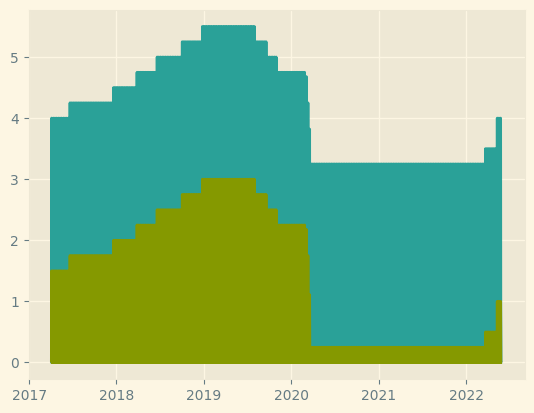

In [302]:
plt.plot(discountRate)

In [156]:
tickerDfResample = pd.DataFrame(tickerDf.resample('1d').sum())
tickerDfResample[tickerDfResample == 0] = None
tickerDfResample = tickerDfResample.interpolate(method='pad')
tickerDfResample = np.log(tickerDfResample)
tickerDfResample

first_diff = tickerDfResample.Close.values[1:]-tickerDfResample.Close.values[:-1]
first_diff = np.concatenate([first_diff,[0]])
tickerDfResample['FirstDifference'] = first_diff
tickerDfResample['PercentageChange'] = tickerDfResample.Close.pct_change().fillna(0) #  "by what percentage did previous value change to get to current value"current value - previous value / previous value = pct change
tickerDfResample

,Open,High,Low,Close,Volume,Dividends,Stock Splits,FirstDifference,PercentageChange
Date,,,,,,,,,
2017-04-03,3.519529,3.522378,3.514926,3.519460,18.196822,NaN,NaN,0.007419,0.000000
2017-04-04,3.516323,3.527707,3.515765,3.526878,18.192092,NaN,NaN,-0.005194,0.002108
2017-04-05,3.523072,3.531633,3.520225,3.521684,18.523883,NaN,NaN,-0.002503,-0.001473
2017-04-06,3.523557,3.525150,3.517719,3.519181,18.253398,NaN,NaN,-0.002230,-0.000711
2017-04-07,3.519669,3.522795,3.516463,3.516952,18.015548,NaN,NaN,0.000000,-0.000634
...,...,...,...,...,...,...,...,...,...
2022-05-27,4.976374,5.005454,4.975480,5.005187,18.326134,-1.469676,1.386294,0.000000,0.008046
2022-05-28,4.976374,5.005454,4.975480,5.005187,18.326134,-1.469676,1.386294,0.000000,0.000000
2022-05-29,4.976374,5.005454,4.975480,5.005187,18.326134,-1.469676,1.386294,0.000000,0.000000


In [157]:
tickerDfResample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1885 entries, 2017-04-03 to 2022-05-31
Freq: D
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              1885 non-null   float64
 1   High              1885 non-null   float64
 2   Low               1885 non-null   float64
 3   Close             1885 non-null   float64
 4   Volume            1885 non-null   float64
 5   Dividends         1847 non-null   float64
 6   Stock Splits      639 non-null    float64
 7   FirstDifference   1885 non-null   float64
 8   PercentageChange  1885 non-null   float64
dtypes: float64(9)
memory usage: 147.3 KB


In [168]:
def ad_test(dataset):
    dftest = adfuller(dataset,autolag = 'AIC')
    print("1. ADF: ",dftest[0])
    print("2. P_value: ",dftest[1])
    print("3. num_lags: ",dftest[2])
    print("4. : ",dftest[3])
    print("5. crit_value: ",dftest[4])
    for key,val in dftest[4].items():
        print("\t",key,": ",val)
        
ad_test(tickerDfResample['FirstDifference'])

1. ADF:  -11.323707593725075
2. P_value:  1.1572945868218323e-20
3. num_lags:  12
4. :  1872
5. crit_value:  {'1%': -3.4338480179204556, '5%': -2.863085177979608, '10%': -2.567592596439203}
	 1% :  -3.4338480179204556
	 5% :  -2.863085177979608
	 10% :  -2.567592596439203


In [169]:
discountRate[['Discount Rate']]

,Discount Rate
Date,
2017-04-03,4.0
2017-04-04,4.0
2017-04-05,4.0
2017-04-06,4.0
2017-04-07,4.0
...,...
2022-05-27,4.0
2022-05-28,4.0
2022-05-29,4.0


In [318]:
warnings.filterwarnings("ignore")
stepwise_fit = auto_arima(tickerDfResample[['Close']],X=discountRate[['Discount Rate']],trace=True,suppress_warnings=False )
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10146.266, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10130.600, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10151.488, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10151.851, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10128.291, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10149.835, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-10149.852, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-10147.861, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-10148.349, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.496 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1885
Model:               SARIMAX(0, 1, 1)   Log Likelihood                5079.926
Date:                Wed, 25 Jan 2023   AIC                         -10151.851
Time:                        12:55:40   BIC                         -10129.686
Sample:                    04-03-2017   HQIC                        -10143.688
                         - 05-31-2022                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0008      0.000      2.299      0.021       0.000       0.001
Discount Rate     0.0010      0.000      2.771      0.006       0.000       0.002
ma.L1            -0.1114      0.015     -7.298      0.000      -0.141      -0.081
sigma2            0.0003   3.82e-06     69.673      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6976.89
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [229]:
warnings.filterwarnings("ignore")
stepwise_fit = auto_arima(tickerDfResample[['Close']],trace=True,suppress_warnings=False )
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10141.490, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10126.274, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10146.910, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10147.331, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10123.980, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10145.316, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-10145.326, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-10143.354, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-10143.853, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.827 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1885
Model:               SARIMAX(0, 1, 1)   Log Likelihood                5076.666
Date:                Wed, 25 Jan 2023   AIC                         -10147.331
Time:                        12:17:56   BIC                         -10130.708
Sample:                    04-03-2017   HQIC                        -10141.209
                         - 05-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.000      2.288      0.022       0.000       0.001
ma.L1         -0.1110      0.015     -7.294      0.000      -0.141      -0.081
sigma2         0.0003    3.7e-06     72.150      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7190.57
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

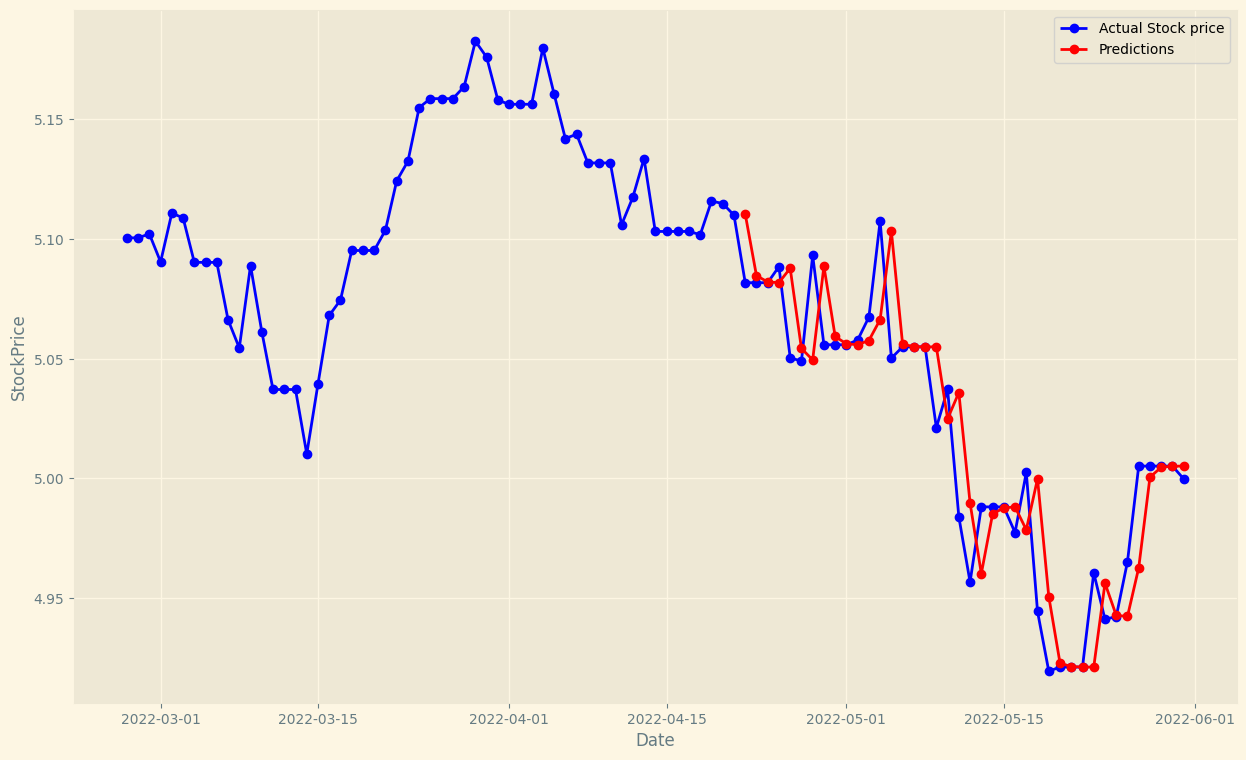

The root mean squared error is:  0.15701221257325287


In [308]:
#close price prediction using SARIMAX
trainData = tickerDfResample['Close'][0:1845]
testData = pd.DataFrame(tickerDfResample['Close'][1845:])
testData['Predictions'] = 0 
for i in range(len(testData)):
    model = SARIMAX(trainData,order=(0,1,1))
    modelFit = model.fit()
   
    futureForcast = modelFit.forecast()
    #futureForcast = np.mean(futureForcast)
    testData['Predictions'][i]=futureForcast
    
    trainData = trainData.append(testData['Close'][i:i+1])
    trainData = trainData[1:]
    
   
    
    
#plot for close price prediction
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15,9))


plt.plot(tickerDfResample['Close'][1790:],'-bo',label='Actual Stock price')
plt.plot(testData['Predictions'],'-ro',label='Predictions')
plt.legend()
plt.xlabel("Date")
plt.ylabel("StockPrice")
plt.show()
print("The root mean squared error is: ",np.sqrt(np.sum(np.square(testData['Close']-testData['Predictions']))))

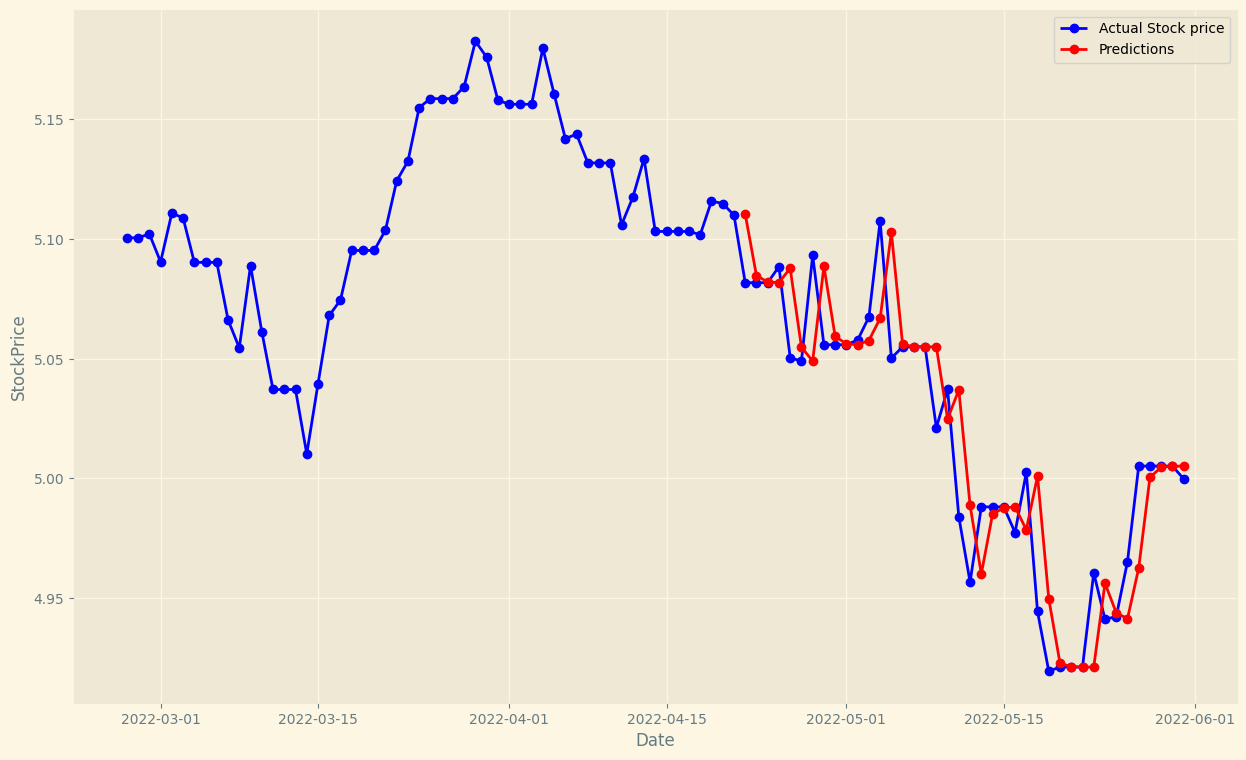

The root mean squared error is:  0.15741551047441688


In [316]:
#close price prediction using exogenous variables

trainData = tickerDfResample['Close'][0:1845]
trainDataExog = discountRate[0:1845]['Discount Rate']   
testData = pd.DataFrame(tickerDfResample['Close'][1845:])
testDataExog =  pd.DataFrame(discountRate[1845:]['Discount Rate'] )   
testData['Predictions'] = 0

for i in range(len(testData)):
    model = SARIMAX(endog=trainData,exog=trainDataExog,order=(0,1,1))
    modelFit = model.fit()

    futureForcast = modelFit.forecast(exog = testDataExog['Discount Rate'][i:i+1])
    #futureForcast = np.mean(futureForcast)
    testData['Predictions'][i]=futureForcast
    
    trainData = trainData.append(testData['Close'][i:i+1])
    trainData = trainData[1:]
    trainDataExog = trainDataExog.append(testDataExog['Discount Rate'][i:i+1])
    trainDataExog = trainDataExog[1:] 
    
    
    
#plot for close price prediction
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15,9))


plt.plot(tickerDfResample['Close'][1790:],'-bo',label='Actual Stock price')
plt.plot(testData['Predictions'],'-ro',label='Predictions')
plt.legend()
plt.xlabel("Date")
plt.ylabel("StockPrice")
plt.show()
print("The root mean squared error is: ",np.sqrt(np.sum(np.square(testData['Close']-testData['Predictions']))))

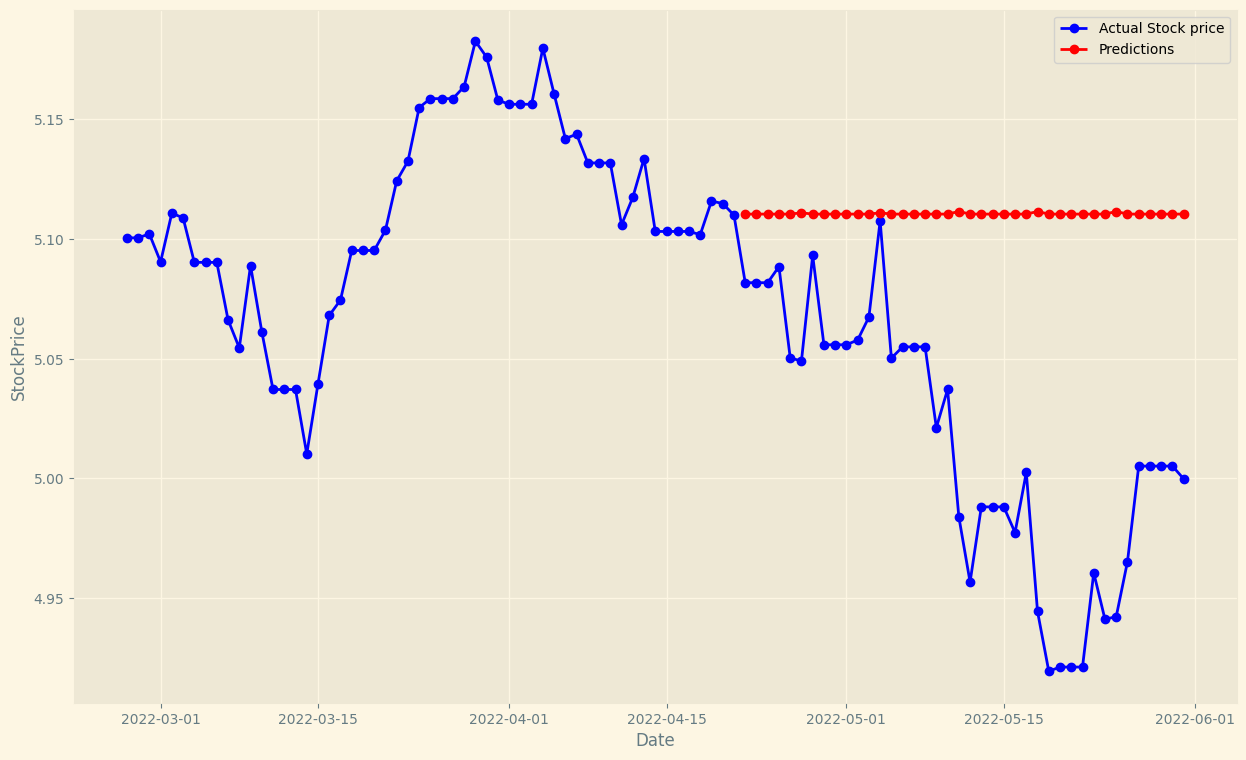

The root mean squared error is:  0.02866044878186358


In [323]:
#forcast price prediction using exogenous variables

trainData = tickerDfResample['Close'][0:1845]
trainDataExog = discountRate['Discount Rate'][0:1845]   
testData = pd.DataFrame(tickerDfResample['Close'][1845:])
testDataExog =  pd.DataFrame(discountRate['Discount Rate'][1845:] )   
testData['Predictions'] = 0


model = SARIMAX(endog=trainData,exog=trainDataExog,order=(0,1,1))
modelFit = model.fit()

futureForcast = modelFit.forecast(len(testData) , exog = testDataExog)

testData['Predictions']=futureForcast
    
    
    
    
#plot for close price prediction
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15,9))


plt.plot(tickerDfResample['Close'][1790:],'-bo',label='Actual Stock price')
plt.plot(testData['Predictions'],'-ro',label='Predictions')
plt.legend()
plt.xlabel("Date")
plt.ylabel("StockPrice")
plt.show()
print("The root mean squared error is: ",np.sqrt(np.sum(np.square(testData['Close'][0:1]-testData['Predictions'][0:1]))))

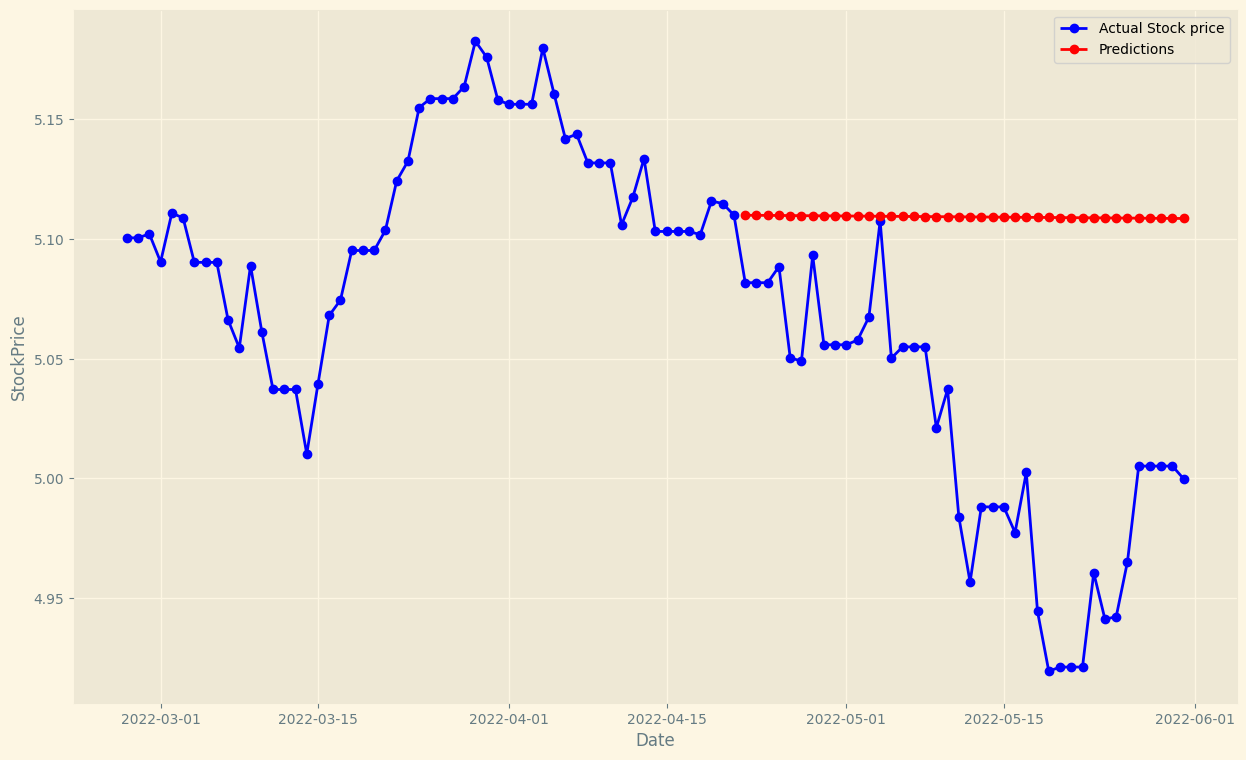

The root mean squared error is:  0.02818055336395453


In [324]:
#forcast price prediction withought exogenous variables

trainData = tickerDfResample['Close'][0:1845]
 
testData = pd.DataFrame(tickerDfResample['Close'][1845:])

testData['Predictions'] = 0


model = SARIMAX(endog=trainData)
modelFit = model.fit()

futureForcast = modelFit.forecast(len(testData))

testData['Predictions']=futureForcast
    
    
    
    
#plot for close price prediction
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15,9))


plt.plot(tickerDfResample['Close'][1790:],'-bo',label='Actual Stock price')
plt.plot(testData['Predictions'],'-ro',label='Predictions')
plt.legend()
plt.xlabel("Date")
plt.ylabel("StockPrice")
plt.show()
print("The root mean squared error is: ",np.sqrt(np.sum(np.square(testData['Close'][0:1]-testData['Predictions'][0:1]))))

In [187]:
#Fbprophet prediction
df = pd.DataFrame(tickerDfResample['Close'][0:1250]).reset_index()
df.columns = ['ds','y']
df['ds'] = df['ds'].dt.tz_localize(None)
testData = pd.DataFrame(tickerDfResample['Close'][1250:])

model = Prophet()
model.fit(df)

11:50:15 - cmdstanpy - INFO - Chain [1] start processing
11:50:16 - cmdstanpy - INFO - Chain [1] done processing


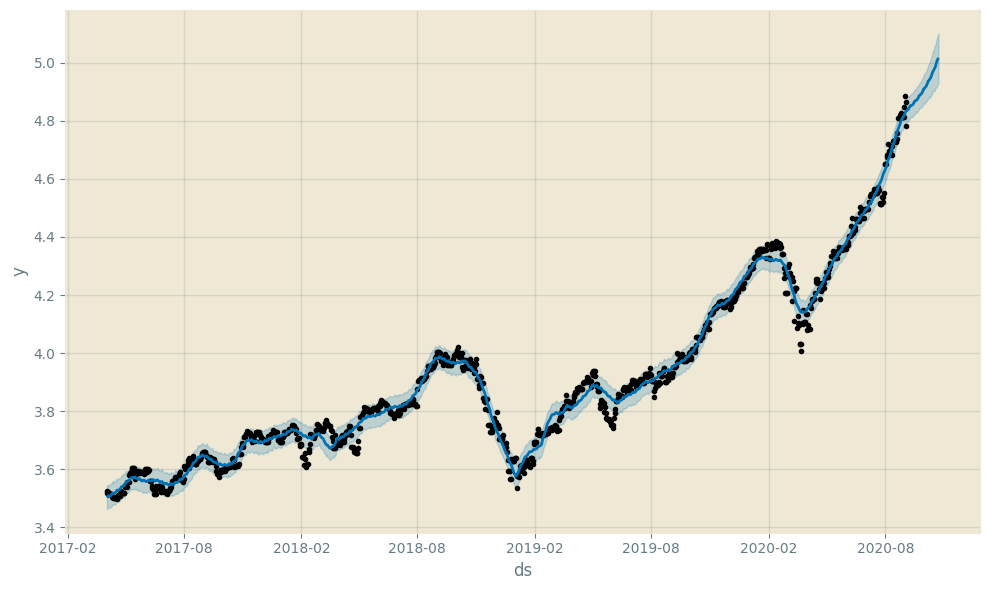

In [188]:
futureDates = model.make_future_dataframe(periods = 50)
prediction = model.predict(futureDates)
fig = model.plot(prediction)